In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
import astropy.table as table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
cvel= const.c.to('km/s').value
import os
#pretty plots


#import stellar kinematics module
from  TardisPipeline.utilities  import util_ppxf
#import emission lines module
from  TardisPipeline.utilities  import util_ppxf_emlines
import ppxf.ppxf_util as util
import TardisPipeline as tardis_module
codedir = os.path.dirname(os.path.realpath(tardis_module.__file__))

# this is the LSF of the MUSE data
#from  TardisPipeline.readData.MUSE_WFM  import get_MUSE_polyFWHM

%matplotlib notebook

In /Users/belfiore/opt/anaconda3/envs/TardisPipeline/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/belfiore/opt/anaconda3/envs/TardisPipeline/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/belfiore/opt/anaconda3/envs/TardisPipeline/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/belfiore/opt/anaconda3/envs/TardisPipeline/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/belfiore/opt/anaconda3/envs/TardisPipeline/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib

In [9]:
#read some test datacube
hdu = fits.open('/Volumes/fbdata2/DATA/Tardis_test/kcwi/ngc5068_kcwi_hii.fits')
# this is the systemic velocity v = c * z of the galaxy
SYS_VEL_GALAXY =667.211

# here we read the data and then extract a single summed spectrum over a square region
hdr = hdu[0].header
wav_fit = hdr['CRVAL3'] + np.arange(hdr['NAXIS3']) * hdr['CDELT3']
flux_fit=hdu[0].data[:, 0, 0]
err_fit=hdu[1].data[:, 0,0]**0.5
mask=hdu[2].data[:, 0, 0]
wav_fit.shape, err_fit.shape

((2024,), (2024, 34))

In [10]:
# set up a dictionary which contains some of the key parameters of the ppxf fit
# ABSOLUTE PATHS NEED TO BE UPDATED ACCORDINGLY!!!
configs = {'SSP_LIB':codedir+'/Templates/spectralTemplates/eMILES-noyoung/', # stellar library to use
           'REDSHIFT':SYS_VEL_GALAXY, 
           'MDEG_EMS':12, 
           'ROOTNAME':'test_KCWI',#name of the output files
           'EMI_FILE':codedir+'/Templates/configurationTemplates/emission_lines_KCWI.setup',  # set of emission lines to fit
           'OUTDIR':'/Volumes/fbdata2/DATA/Tardis_test/kcwi/', #where do you want results to be saved?
           'MASK_WIDTH':400, #width in km/s to mask around line
           'MOM':4,
           'GAS_MOMENTS':4,
           'WAV_VACUUM':True,
           'PARALLEL':False, 'NCPU':1, 
           'ADEG':12, 'MC_PPXF':0, 'MDEG':0
          }

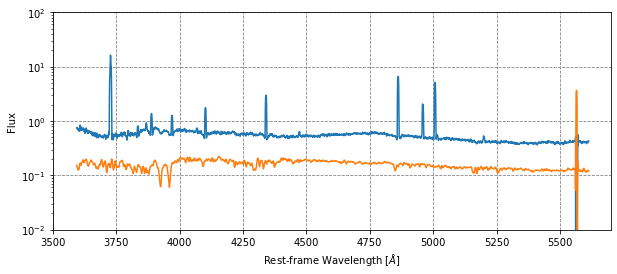

In [8]:


plt.figure(figsize=(10, 4))
plt.plot(wav_fit /(1+SYS_VEL_GALAXY/cvel), flux_fit)
plt.plot(wav_fit /(1+SYS_VEL_GALAXY/cvel), err_fit)
plt.xlim(3500,5700)
plt.ylim(0.01, 100)
plt.yscale('log')
plt.xlabel('Rest-frame Wavelength [$\AA$]')
plt.ylabel('Flux')
plt.grid(ls='--', color='gray')

In [11]:

#input spectra needs to be log-rebinned
velscale = 20 #size of the pixel in km/s after log-rebinning, you need to choose something that makes sense 
lamrange = np.array([ wav_fit[0], wav_fit[-1]])
log_spec, logLam, velscale = util.log_rebin(lamrange, flux_fit, velscale=velscale)
log_err, _, _ = util.log_rebin(lamrange, err_fit, velscale=velscale)

#in this example we take the error as arbitrary arrays of 1, 
#errors needs to be set it to 9999 when the flux is noy finite
ww = (np.isfinite(log_spec)==0) | (log_err<=0) 
log_err[ww]=9999
log_spec[ww]=0.

AssertionError: input spectrum must be a vector

<IPython.core.display.Javascript object>


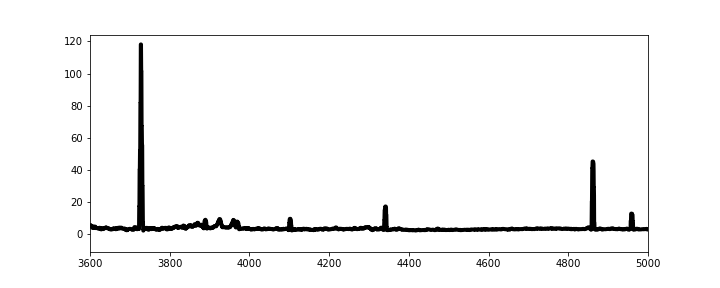

(3600.0, 5000.0)

In [82]:
plt.figure(figsize=(10, 4))
plt.plot(np.exp(logLam)  /(1+SYS_VEL_GALAXY/cvel), log_spec/log_err, c='k', lw=4)
#plt.plot(wav_fit /(1+SYS_VEL_GALAXY/cvel), flux_fit/log_err, c='r')
plt.xlim(3600,5000)
#plt.ylim(0,None)

In [97]:
# define the LSF of the KCWI data
LSF = np.zeros_like(log_spec)+0.001

# NOW YOU ARE ALL READY TO FIT!!!
# this is the stellar kinematics ppxf wrapper function
ppxf_result = util_ppxf.runModule_PPXF(configs, logLam, log_spec, log_err, LSF)
#ppxf_result=np.array([[88, 2]])
# this the ppxf wrapper function to simulataneously fit the continuum plus emission lines
util_ppxf_emlines.runModule_PPXF_emlines(configs,logLam, log_spec, 
            log_err, LSF,ppxf_results=ppxf_result)

 - - - - - Running Stellar Kinematics Extraction - - - - - 
 [ RUNNING ] Preparing the stellar population templates


 [ WARNING ] The templates are defined in air but the data is in vacuum wavelength. I am converting the templates wavelength into vacuum 
 [ DONE    ] Preparing the stellar population templates
 [ RUNNING ] Running PPXF in serial mode
 [ DONE    ] Running PPXF in serial mode       | 0.0% 
Running PPXF on 1 spectra took 1.69s
 [ RUNNING ] Writing: test_KCWI_ppxf.fits
 [ DONE    ] Writing: test_KCWI_ppxf.fits
 [ RUNNING ] Writing: test_KCWI_ppxf-bestfit.fits
 [ DONE    ] Writing: test_KCWI_ppxf-bestfit.fits
 - - - - - Stellar Kinematics done! - - - - -
 - - - - - Running Emission Lines Fitting - - - - - 
 [ RUNNING ] Preparing the stellar population templates


 [ WARNING ] The templates are defined in air but the data is in vacuum wavelength. I am converting the templates wavelength into vacuum 
 [ DONE    ] Preparing the stellar population templates
 [ RUNNING ] Running PPXF in serial mode
 [ DONE    ] Running PPXF in serial mode       | 0.0% 
             Running PPXF on 1 spectra took 40.93s
 [ RUNNING ] Writing: test_KCWI_emlines.fits
 [ DONE    ] Writing: test_KCWI_emlines.fits
 [ RUNNING ] Writing: test_KCWI_ppxf-bestfit-emlines.fits
 [ DONE    ] Writing: test_KCWI_ppxf-bestfit-emlines.fits
 - - - - - Emission Lines Fitting done! - - - - -


In [70]:
ppxf_result

array([[-1.58377071e-02,  1.00789021e+02, -1.98658819e-03,
        -2.66577803e-03]])

In [ ]:
# read the output file which contains the best-fit from the emission lines fitting stage
ppxf_bestfit_gas=configs['OUTDIR']+configs['ROOTNAME']+'_ppxf-bestfit-emlines.fits'
hdu3 = fits.open(ppxf_bestfit_gas)
bestfit_gas = hdu3['FIT'].data["BESTFIT"][0]
mask=(hdu3['FIT'].data['BESTFIT'][0]==0)
gas_templ =hdu3['FIT'].data["GAS_BESTFIT"][0]


ppxf_bestfit=configs['OUTDIR']+configs['ROOTNAME']+'_ppxf-bestfit.fits'
hdu3 = fits.open(ppxf_bestfit)
bestfit_stkin = hdu3['FIT'].data["BESTFIT"][0]
mask_stkin=(hdu3['FIT'].data['BESTFIT'][0]==0)


plt.figure(figsize=(12,6))
plt.plot(np.exp( logLam)  /(1+SYS_VEL_GALAXY/cvel), log_spec, c='k', 
         label='data')
plt.plot(np.exp( logLam)  /(1+SYS_VEL_GALAXY/cvel), bestfit_gas, c='r', 
         label='best fit model')
plt.plot(np.exp( logLam ) /(1+SYS_VEL_GALAXY/cvel), bestfit_stkin, c='orange', 
         label='stellar kinametics model')
#plt.scatter(np.exp( logLam ), log_spec-bestfit_gas, c='k', label='residuals', s=1)
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Flux')
plt.grid(ls='--', color='gray')
plt.xlim(3600, 5050)
plt.ylim(0.2, 100)
plt.yscale('log')
plt.legend()

plt.savefig('example_fit1.png', dpi=300)

In [62]:
#if you want to access emission line fluxes you can load the emlines file
emlines=configs['OUTDIR']+configs['ROOTNAME']+'_emlines.fits'
hdu4 = fits.open(emlines)
ems = table.Table(hdu4['EMLDATA_DATA'].data)
ems

<Table length=1>
BIN_ID       V_STARS2       ...      OIII5008_H3      OIII5008_H4
int32        float64        ...        float64          float64  
------ -------------------- ... --------------------- -----------
     0 0.019867158163331733 ... -0.024297807237144704       0.001

In [85]:
ems[ 'OIII4364_FLUX']/ems['OIII4364_FLUX_ERR' ]

<Column name='OIII4364_FLUX' dtype='float64' length=1>
0.7769970273724136

In [61]:
#if you want to access emission line fluxes you can load the emlines file
stkin=configs['OUTDIR']+configs['ROOTNAME']+'_ppxf.fits'
hdu4 = fits.open(stkin)
stk = table.Table(hdu4['PPXF_DATA'].data)
stk

<Table length=1>
BIN_ID         CHI2        ...    FORM_ERR_H3         FORM_ERR_H4    
int32        float64       ...      float64             float64      
------ ------------------- ... ------------------ -------------------
     0 0.34581332952425836 ... 0.2738853346426381 0.28975708797691085

In [30]:
configs['OUTDIR']+configs['ROOTNAME']

'/Volumes/fbdata2/DATA/Tardis_test/kcwi/test_KCWI'